In [4]:
import numpy as np
import tensorflow as tf
from art.attacks.evasion import CarliniL2Method
from art.estimators.classification import TensorFlowV2Classifier
import matplotlib.pyplot as plt


In [5]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [6]:
# Preprocess data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)


In [7]:
# Use a smaller subset of the dataset
subset_size = 10  # Adjust this size as needed
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]

In [8]:
# Create a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(100, activation="softmax")
])

D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [10]:
# Train the model
model.fit(x_train, y_train, epochs=10, validation_split=0.1, batch_size=64)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.0368 - loss: 4.3626 - val_accuracy: 0.1226 - val_loss: 3.7592
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.1425 - loss: 3.6289 - val_accuracy: 0.1824 - val_loss: 3.4174
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2038 - loss: 3.2712 - val_accuracy: 0.2138 - val_loss: 3.2242
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2545 - loss: 3.0480 - val_accuracy: 0.2598 - val_loss: 3.0154
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2857 - loss: 2.8789 - val_accuracy: 0.2714 - val_loss: 2.9624
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3088 - loss: 2.7518 - val_accuracy: 0.2722 - val_loss: 2.9506
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3304 - loss: 2.6634 - val_accuracy: 0.2968 - val_loss: 2.7840
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3497 - loss: 2.5636 - val_accurac

In [11]:
# Define the loss function
loss_object = tf.keras.losses.CategoricalCrossentropy()


In [12]:
# Create ART classifier with loss function
classifier = TensorFlowV2Classifier(model=model, nb_classes=100, input_shape=(32, 32, 3), loss_object=loss_object)

In [13]:
# Initialize C&W attack
attack = CarliniL2Method(classifier=classifier, confidence=0.0, learning_rate=0.01, binary_search_steps=5, max_iter=10)

In [14]:
# Iterate over a range of eps values
eps_values = np.linspace(0.0, 0.01, num=5)
accuracies = []

for eps in eps_values:
    # Generate adversarial examples
    x_adv = attack.generate(x=x_test_subset, eps=eps)

    # Evaluate model accuracy on adversarial examples
    accuracy = np.mean(np.argmax(classifier.predict(x_adv), axis=1) == np.argmax(y_test_subset, axis=1))
    accuracies.append(accuracy)

C&W L_2:   0%|          | 0/10 [00:00<?, ?it/s]

C&W L_2: 100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


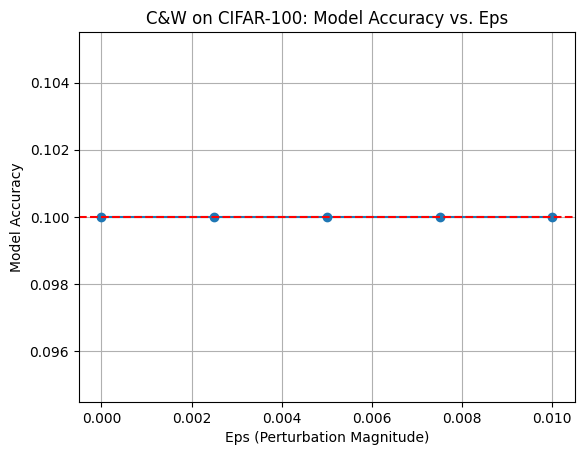

Maximum eps value after which the model fails (accuracy <= 10%): 0.00


In [15]:
# Plot the graph
plt.plot(eps_values, accuracies, marker="o")
plt.axhline(y=0.1, color='r', linestyle='--')
plt.xlabel("Eps (Perturbation Magnitude)")
plt.ylabel("Model Accuracy")
plt.title("C&W on CIFAR-100: Model Accuracy vs. Eps")
plt.grid(True)
plt.show()

print(f"Maximum eps value after which the model fails (accuracy <= 10%): {eps_values[np.where(np.array(accuracies) <= 0.1)[0][0]]:.2f}")